In [1]:
import requests
from html.parser import HTMLParser
from bs4 import BeautifulSoup
import urllib.request
from selenium import webdriver
import pandas as pd
import csv
import time
import operator
import re
import random
import networkx as nx

In [2]:
random.seed(42)

In [3]:
#main sourcde url 
#construction accident -> search keyword
m_url ="https://www.nytimes.com/search?dropmab=false&endDate=20200229&query=%22construction%22%20accident&sort=best&startDate=20000101"

In [5]:
session = requests.Session()
req=session.get(m_url) #default is s_url
soup = BeautifulSoup(req.text, 'html.parser')




In [4]:
#m_url ="https://www.nytimes.com/search?dropmab=false&endDate=20200229&query=%22construction%22%20accident&sort=best&startDate=20000101"

chrome_options = webdriver.ChromeOptions
driver = webdriver.Chrome(executable_path='/Users/macbookpro/Project_construction/chromedriver')

link = []
driver.get(m_url)
time.sleep(3)
for i in range(100) :
    a = driver.page_source
    b = BeautifulSoup(a, 'html.parser')
    c = b.select('#site-content > div >div>div> ol >li> div > div > div > a')
    
    for j in range(len(c)) :
        if c[j].attrs['href'] not in link :
            link.append(c[j].attrs['href'])
        else :
            pass
    
    driver.find_element_by_xpath('//*[@id="site-content"]/div/div[2]/div[2]/div/button').click()
    time.sleep(3)



In [7]:
link_source = link 

a_link = link

print(len(a_link))


1000


In [8]:
diff_link = []

#delete unsupported news 
for i in range (len(a_link)) :
    print(a_link[i])
    if a_link[i][1] != '2':
        
        diff_link.append(a_link[i])
            
    else : 
        continue

for j in range(len(diff_link)):
    if diff_link[j] in a_link:
        a_link.remove(diff_link[j])
        



/2020/02/17/nyregion/construction-deaths-latinos-nyc.html?searchResultPosition=1
/2020/01/30/nyregion/nyc-scaffolding-building-facades.html?searchResultPosition=2
/2019/11/22/nyregion/nyc-dob-surprise-inspectors.html?searchResultPosition=3
/2019/11/29/us/hard-rock-hotel-worker-immigration.html?searchResultPosition=4
/2007/09/13/nyregion/13mbrfs-DEATHS.html?searchResultPosition=5
/2015/06/03/nyregion/fatal-construction-accidents-are-rising-in-new-york.html?searchResultPosition=6
/2006/11/22/nyregion/fatal-construction-accidents-in-the-city-rise-sharply-over-12.html?searchResultPosition=7
/2006/11/22/nyregion/22construct.html?searchResultPosition=8
/2007/05/05/nyregion/05cave.html?searchResultPosition=9
https://cityroom.blogs.nytimes.com/2008/04/29/more-construction-accidents-2-workers-critically-injured/?searchResultPosition=10
/2002/08/27/nyregion/city-allows-work-to-resume-at-construction-accident-site.html?searchResultPosition=11
https://cityroom.blogs.nytimes.com/2007/08/23/new-scaf

In [9]:
## This is main source for analyzing article

class ArticleInfo():
    
    def __init__(self, s_url) :
        
        session = requests.Session()
        req=session.get(s_url)
        self.soup = BeautifulSoup(req.text, 'html.parser')
    
    
    def article_body(self) :
        body = self.soup.find('div', {'class' : 'StoryBodyCompanionColumn'})
        finalContent =''
    
        if body is not None :
            for itcontents in self.soup.findAll('p'):
                if itcontents == None :
                    continue
                content = itcontents.getText()
                content = re.sub(r"\n+", "", content)
                finalContent +=content
        else :
            return False
        
        return finalContent

##reference: https://github.com/subhendusethi/nytimes-article-crawler/blob/master/crawler/nytimescrawler.py    

    def article_title(self):
        titles = self.soup.select('title',{"data-rh":"true"})
        for title in titles:
            title = title.getText()
            break
        return title

    def article_date(self) :
  
        date = self.soup.find('li',{'class':'date'})
        if date != None :
            date = date.getText()
            
        else :
            date = self.soup.find('meta',{'name':'pdate'})
            if date !=None :
                date = date.get('content')
                if date !=None :
                    date = str(date)
                else:
                    none= "none"
                    datelist.append(none)
                
        return date

 

In [10]:
titles =[]
bodies =[]
datelist=[]

for s_url in a_link :
    s_url = 'https://www.nytimes.com'+s_url
    ob = ArticleInfo(s_url)
    
    body =ob.article_body()
    bodies.append(body)
    
    date = ob.article_date()
    datelist.append(date)
    
    title = ob.article_title()
    titles.append(title)

In [1085]:
datelist

['20200217',
 '20200130',
 '20191122',
 '20191129',
 '20070913',
 '20150602',
 '20061122',
 '20061122',
 '20070505',
 '20020827',
 '20040608',
 '20080612',
 '20161122',
 '20191012',
 '20190827',
 '20190909',
 '20001228',
 '20150424',
 '20140923',
 '20000728',
 '20080605',
 '20080129',
 '20141103',
 '20080209',
 '20000208',
 '20080519',
 '20131127',
 '20071019',
 '20080601',
 '20021207',
 '20090713',
 '20160610',
 '20080530',
 '20080507',
 '20020321',
 '20190428',
 '20000818',
 '20051018',
 '20061122',
 '20080429',
 '20061122',
 '20110110',
 '20040425',
 '20080919',
 '20010608',
 '20020502',
 '20071208',
 '20150505',
 '20070104',
 '20080313',
 '20080415',
 '20021220',
 '20010817',
 '20080625',
 '20160713',
 '20061003',
 '20170510',
 '20010509',
 '20170901',
 '20080507',
 '20061003',
 '20060522',
 '20160502',
 '20090318',
 '20150825',
 '20080602',
 '20151210',
 '20020820',
 '20040218',
 '20080130',
 '20161124',
 '20080115',
 '20080904',
 '20150407',
 '20060523',
 '20080430',
 '20080530',

In [1068]:
weather =[]
month = []
for i in range(len(df_article)) :
    
    if df_article.loc[i,'date'] is None :
        weather.append('None')
        month.append('None')
    else :
        if df_article.loc[i,"date"][4:6] == '03':
            weather.append('spring')
            month.append('march')
        elif df_article.loc[i,"date"][4:6] == '04' :
            weather.append('spring')
            month.append('april')
        elif df_article.loc[i,"date"][4:6] == '05' :
            weather.append('spring')
            month.append('may')
        elif df_article.loc[i,"date"][4:6] == "06" :
            weather.append('summer')
            month.append('june')
        elif df_article.loc[i,"date"][4:6] == "07" :
            weather.append('summer')
            month.append('july')
        elif df_article.loc[i,"date"][4:6] == "08" :
            weather.append('summer')
            month.append('august')
        elif df_article.loc[i,"date"][4:6] == "09" :
            weather.append('fall')
            month.append('september')
        elif df_article.loc[i,"date"][4:6] == "10" :
            weather.append('fall')
            month.append('october')
        elif df_article.loc[i,"date"][4:6] == "11" :
            weather.append('fall')
            month.append('november')
        elif df_article.loc[i,"date"][4:6] == "12" :
            weather.append('winter')
            month.append('december')
        elif df_article.loc[i,"date"][4:6] == "01" :
            weather.append('winter')
            month.append('january')
        elif df_article.loc[i,"date"][4:6] == "02" :
            weather.append('winter')
            month.append('february')
        else :
            weatehr.append('error')

print(len(weather))
df_article.insert(3, "weather", weather)
df_article.insert(4, "month", month)

861


In [1069]:
df_article

,date,title,bodies,weather,month
0,20200217,"A Latino Worker, a Risky Construction Site and...","[advertisementsupported, byconstruction, worke...",winter,february
1,20200130,"Facades on 1,400 Buildings in New York Are a T...","[advertisementsupported, bylandlords, flout, l...",winter,january
2,20191122,"11,484 Violations: Surprise Inspections Hit N....","[advertisementsupported, “, get, rid, right, ,...",fall,november
3,20191129,Witness in Hard Rock Hotel Collapse Is Deporte...,"[advertisementsupported, bya, construction, wo...",fall,november
4,20070913,Increase in Fatal Construction Accidents - The...,"[advertisementsupported, bynew, yorkby, patric...",fall,september
...,...,...,...,...,...
856,20101118,Traffic Roundabouts Spread in U.S. - The New Y...,"[advertisementsupported, byby, andrew, kehtraf...",fall,november
857,20110405,Spain and U.S. Near Accord on Atomic Cleanup -...,"[advertisementsupported, byby, raphael, minder...",spring,april
858,20100915,Hayward Defends BP’s Safety Record - The New Y...,"[advertisementsupported, byby, julia, werdigie...",fall,september
859,20170109,New York City’s Fire Deaths Reach Lowest Point...,"[advertisementsupported, byby, j., david, good...",winter,january


In [1039]:
for i in range(len(df_article)): 
    if df_article.loc[i,"date"] is not None :
        if df_article.loc[i, "date"][0:4] == '2020' :
            print('True')
            
# 2020 -> 5 articles includede

True
True
True
True
True


### Basic Stats

Distrubution of weather naively

In [1070]:


def get_dist_weather(df) :
    spring_cnt = 0
    summer_cnt =0
    fall_cnt =0
    winter_cnt = 0
    none_cnt = 0
    for i in range(len(df)) :
        if df.loc[i,"weather"] =='spring' :
            spring_cnt +=1
        elif df.loc[i,"weather"] =='summer' :
            summer_cnt +=1
        elif df.loc[i,"weather"] =='fall' :
            fall_cnt +=1
        elif df.loc[i,"weather"] =='winter' :
            winter_cnt +=1
        else :
            none_cnt +=1
    
    fin_set = {}
    fin_set['spring'] = spring_cnt
    fin_set['summer'] = summer_cnt
    fin_set['fall'] = fall_cnt
    fin_set['winter'] = winter_cnt
    fin_set['none'] = none_cnt
    
    return fin_set


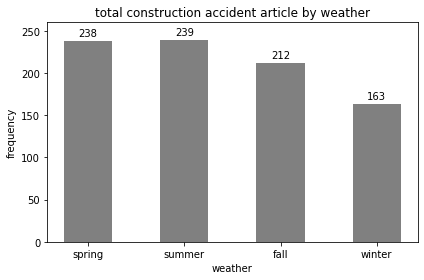

In [1150]:
dist_weather = get_dist_weather(df_article)


fig, ax = plt.subplots()
rect1 = ax.bar(list(dist_weather.keys())[:-1],list(dist_weather.values())[:-1],width = 0.5, color ='gray')
ax.set_ylabel('frequency')
ax.set_xlabel('weather')
ax.set_ylim(0,260)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rect1)        
        
#plt.title("Frequency of keywords")
plt.title("total construction accident article by weather")
fig.tight_layout()


plt.savefig('Figure/word2vec/weather_distribution.png')


Distrubution of weather with fire

In [1072]:
def get_dist_weather_keyword(df,key) :
    spring_cnt = 0
    summer_cnt =0
    fall_cnt =0
    winter_cnt = 0
    none_cnt = 0
    for i in range(len(df)) :
        if df.loc[i,"weather"] =='spring' :
            #print(type(df.loc[i,"bodies"]))
            if key in df.loc[i,"bodies"] :
                spring_cnt +=1
        elif df.loc[i,"weather"] =='summer' :
            if key in df.loc[i,"bodies"] :
                summer_cnt +=1
        elif df.loc[i,"weather"] =='fall' :
            if key in df.loc[i,"bodies"] :
                fall_cnt +=1
        elif df.loc[i,"weather"] =='winter' :
            if key in df.loc[i,"bodies"] :
                winter_cnt +=1
        else :
                none_cnt +=0
    
    fin_set_fire = {}
    fin_set_fire['spring'] = spring_cnt
    fin_set_fire['summer'] = summer_cnt
    fin_set_fire['fall'] = fall_cnt
    fin_set_fire['winter'] = winter_cnt
    fin_set_fire['none'] = none_cnt
    
    return fin_set_fire


In [1075]:
get_dist_weather_keyword(df_article,"explosion")


{'spring': 12, 'summer': 14, 'fall': 15, 'winter': 18, 'none': 0}

In [1113]:
def get_dist_month(df) :
    jan_cnt = 0
    feb_cnt = 0 
    mar_cnt = 0
    apr_cnt = 0 
    may_cnt = 0 
    jun_cnt = 0
    jul_cnt = 0
    aug_cnt = 0
    sep_cnt = 0
    ocb_cnt = 0
    nov_cnt = 0
    dec_cnt = 0
    none_cnt = 0
    for i in range(len(df)) :
        if df.loc[i,"month"] =='january' :
            #print(type(df.loc[i,"bodies"]))
       
            jan_cnt +=1
        elif df.loc[i,"month"] =='february' :
        
            feb_cnt +=1
        elif df.loc[i,"month"] =='march' :
        
            mar_cnt +=1
        elif df.loc[i,"month"] =='april' :
   
            apr_cnt +=1
        elif df.loc[i,"month"] =='may' :
     
            may_cnt +=1
        elif df.loc[i,"month"] =='june' :
            
            jun_cnt +=1
        elif df.loc[i,"month"] =='july' :
          
            jul_cnt +=1
        elif df.loc[i,"month"] =='august' :
           
            aug_cnt +=1
        elif df.loc[i,"month"] =='september' :
          
            sep_cnt +=1
        elif df.loc[i,"month"] =='october' :
           
            ocb_cnt +=1
        elif df.loc[i,"month"] =='november' :
            
            nov_cnt +=1
        elif df.loc[i,"month"] =='december' :
            
            dec_cnt +=1
        else :
            none_cnt +=1
    
    fin_set_mon = {}
    fin_set_mon['january'] = jan_cnt
    fin_set_mon['february'] = feb_cnt
    fin_set_mon['march'] = mar_cnt
    fin_set_mon['april'] = apr_cnt
    fin_set_mon['may'] = may_cnt
    fin_set_mon['june'] = jun_cnt
    fin_set_mon['july'] = jul_cnt
    fin_set_mon['august'] = aug_cnt
    fin_set_mon['september'] = sep_cnt
    fin_set_mon['octoboer'] = ocb_cnt
    fin_set_mon['november'] = nov_cnt
    fin_set_mon['december'] = dec_cnt
    fin_set_mon['none'] = none_cnt
    
    
    return fin_set_mon


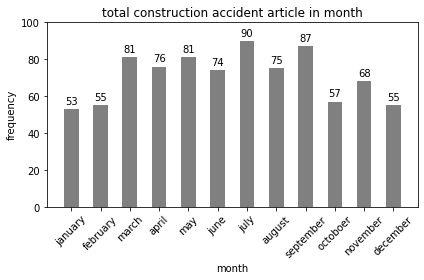

In [1151]:
dist_month = get_dist_month(df_article)

fig, ax = plt.subplots()
rect1 = ax.bar(list(dist_month.keys())[:-1],list(dist_month.values())[:-1],width = 0.5, color ='gray')
ax.set_ylabel('frequency')
ax.set_xlabel('month')

ax.set_ylim(0,100)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rect1)        
        
#plt.title("Frequency of keywords")

plt.xticks(list(dist_month.keys())[:-1], rotation= 45)
plt.title("total construction accident article in month")
fig.tight_layout()
plt.savefig('Figure/word2vec/month_distribution.png')
plt.show()

In [1093]:
def get_dist_month_keyword(df,key) :
    jan_cnt = 0
    feb_cnt = 0 
    mar_cnt = 0
    apr_cnt = 0 
    may_cnt = 0 
    jun_cnt = 0
    jul_cnt = 0
    aug_cnt = 0
    sep_cnt = 0
    ocb_cnt = 0
    nov_cnt = 0
    dec_cnt = 0
    none_cnt = 0
    for i in range(len(df)) :
        if df.loc[i,"month"] =='january' :
            #print(type(df.loc[i,"bodies"]))
            if key in df.loc[i,"bodies"] :
                jan_cnt +=1
        elif df.loc[i,"month"] =='february' :
            if key in df.loc[i,"bodies"] :
                feb_cnt +=1
        elif df.loc[i,"month"] =='march' :
            if key in df.loc[i,"bodies"] :
                mar_cnt +=1
        elif df.loc[i,"month"] =='april' :
            if key in df.loc[i,"bodies"] :
                apr_cnt +=1
        elif df.loc[i,"month"] =='may' :
            if key in df.loc[i,"bodies"] :
                may_cnt +=1
        elif df.loc[i,"month"] =='june' :
            if key in df.loc[i,"bodies"] :
                jun_cnt +=1
        elif df.loc[i,"month"] =='july' :
            if key in df.loc[i,"bodies"] :
                jul_cnt +=1
        elif df.loc[i,"month"] =='august' :
            if key in df.loc[i,"bodies"] :
                aug_cnt +=1
        elif df.loc[i,"month"] =='september' :
            if key in df.loc[i,"bodies"] :
                sep_cnt +=1
        elif df.loc[i,"month"] =='october' :
            if key in df.loc[i,"bodies"] :
                ocb_cnt +=1
        elif df.loc[i,"month"] =='november' :
            if key in df.loc[i,"bodies"] :
                nov_cnt +=1
        elif df.loc[i,"month"] =='december' :
            if key in df.loc[i,"bodies"] :
                dec_cnt +=1
        else :
                none_cnt +=0
    
    fin_set_mon = {}
    fin_set_mon['january'] = jan_cnt
    fin_set_mon['february'] = feb_cnt
    fin_set_mon['march'] = mar_cnt
    fin_set_mon['april'] = apr_cnt
    fin_set_mon['may'] = may_cnt
    fin_set_mon['june'] = jun_cnt
    fin_set_mon['july'] = jul_cnt
    fin_set_mon['august'] = aug_cnt
    fin_set_mon['september'] = sep_cnt
    fin_set_mon['octoboer'] = ocb_cnt
    fin_set_mon['november'] = nov_cnt
    fin_set_mon['december'] = dec_cnt
    fin_set_mon['none'] = none_cnt
    
    
    return fin_set_mon


In [1120]:
get_dist_month_keyword(df_article,'collapse')

{'january': 14,
 'february': 16,
 'march': 39,
 'april': 27,
 'may': 37,
 'june': 32,
 'july': 30,
 'august': 23,
 'september': 18,
 'octoboer': 18,
 'november': 14,
 'december': 16,
 'none': 0}

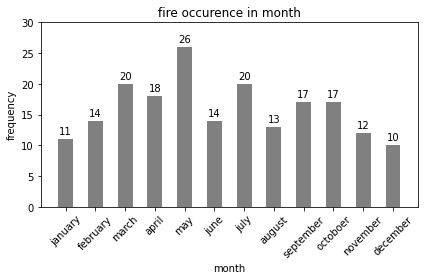

In [1152]:
dist_month_fire = get_dist_month_keyword(df_article,'fire')

fig, ax = plt.subplots()
rect1 = ax.bar(list(dist_month_fire.keys())[:-1],list(dist_month_fire.values())[:-1],width = 0.5, color ='gray')
ax.set_ylabel('frequency')
ax.set_xlabel('month')

ax.set_ylim(0,30)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rect1)        
        
#plt.title("Frequency of keywords")

plt.xticks(list(dist_month.keys())[:-1], rotation= 45)
plt.title("fire occurence in month")
fig.tight_layout()
plt.savefig('Figure/word2vec/month_fire_distribution.png')
plt.show()

### Start Tokenize words with nltk

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer,word_tokenize
from nltk.probability import ConditionalFreqDist
from gensim.models import Word2Vec
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:

#1. make lower case, regulazation
l_bodies=[]
for body in bodies :
    
    body = str(body).lower()
    l_bodies.append(body)

    
#2. removing stop words, tokenize
stop_words = set(stopwords.words('english'))

token_sentence = []
for words in l_bodies:
    word_tokens= word_tokenize(words)
    filter_sentence = [fw for fw in word_tokens if not fw in stop_words]
    
    for n in range(len(filter_sentence)) :
        if filter_sentence[n] == 'collapsed' :
            filter_sentence[n]  = 'collapse'
        elif filter_sentence[n] == 'buildings':
            filter_sentence[n] = 'building'
       
    ## fall + fell => fall (less frequency of fall just go with fell) , collapsed +collapse => collapse
    #filter_sentence = nltk.pos_tag(filter_sentence)
    token_sentence.append(filter_sentence)
    
#token_sentence
#print(l_bodies)



In [1033]:
#check how many words I use 

len(token_sentence)
total_word_count = 0
for i in range(len(token_sentence)) :
    
    total_word_count += len(token_sentence[i])
print(total_word_count)
print(len(token_sentence))
print(len(l_bodies))

453283
861
861


In [1067]:
article_set ={}
article_set['date'] = datelist
article_set['title'] = titles
article_set['bodies'] = token_sentence

df_article = pd.DataFrame(article_set, columns = ['date','title','bodies'])
df_article

,date,title,bodies
0,20200217,"A Latino Worker, a Risky Construction Site and...","[advertisementsupported, byconstruction, worke..."
1,20200130,"Facades on 1,400 Buildings in New York Are a T...","[advertisementsupported, bylandlords, flout, l..."
2,20191122,"11,484 Violations: Surprise Inspections Hit N....","[advertisementsupported, “, get, rid, right, ,..."
3,20191129,Witness in Hard Rock Hotel Collapse Is Deporte...,"[advertisementsupported, bya, construction, wo..."
4,20070913,Increase in Fatal Construction Accidents - The...,"[advertisementsupported, bynew, yorkby, patric..."
...,...,...,...
856,20101118,Traffic Roundabouts Spread in U.S. - The New Y...,"[advertisementsupported, byby, andrew, kehtraf..."
857,20110405,Spain and U.S. Near Accord on Atomic Cleanup -...,"[advertisementsupported, byby, raphael, minder..."
858,20100915,Hayward Defends BP’s Safety Record - The New Y...,"[advertisementsupported, byby, julia, werdigie..."
859,20170109,New York City’s Fire Deaths Reach Lowest Point...,"[advertisementsupported, byby, j., david, good..."


In [1238]:
#frequency of five keywords

cnt_fire =0 
cnt_fall =0
cnt_collapse =0 
cnt_people = 0
cnt_building = 0
for token in token_sentence :
    if 'fire' in token :
        cnt_fire +=1
    if 'collapse' in token :
        cnt_collapse +=1
    if 'fell' in token :
        cnt_fall +=1
    if 'building' in token :
        cnt_building +=1
    if 'people' in token :
        cnt_people +=1
        
freq_dict = {}
freq_dict['fire'] = cnt_fire
freq_dict['fell'] = cnt_fall
freq_dict['collapsed'] = cnt_collapse
freq_dict['building'] = cnt_building
freq_dict['people'] = cnt_people
print(cnt_fire, cnt_fall, cnt_collapse)
print(len(token_sentence))
type(cnt_people)

192 233 284
861


int

{'fire': 192, 'fell': 233, 'collapsed': 284, 'building': 514, 'people': 492}


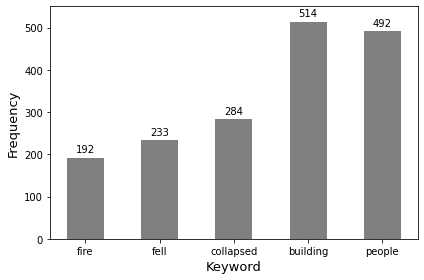

In [1319]:
#frequency histogram of five keywords

import matplotlib.pyplot as plt
print(freq_dict)



#plt.bar(list(freq_dict.keys()),freq_dict.values(),width = 0.5, color ='gray')
#plt.title("Frequency of keywords")
#plt.savefig('Figure/word2vec/frequency_keyword.pdf')



fig, ax = plt.subplots()
rect1 = ax.bar(list(freq_dict.keys()),list(freq_dict.values()),width = 0.5, color ='gray')
ax.set_ylabel('Frequency', fontsize = 13)
ax.set_xlabel('Keyword', fontsize = 13)

ax.set_ylim(0,550)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rect1)        
        
#plt.title("Frequency of keywords")

plt.xticks(list(freq_dict.keys()))
#plt.title("fire occurence in month")
fig.tight_layout()
plt.savefig('Figure/word2vec/frequency_keyword.pdf')
plt.show()

In [696]:
#start word2vec
from gensim.models import Word2Vec
model = Word2Vec(token_sentence, size = 400, window=5, min_count=200, workers=3, sg=0, iter=5)

In [1158]:
#check similarty between 5 keywords (total 10)
#fire - collapse, fire - fell, fire - people, fire - building
#collapse - fell, collapse - people , collapse - building
#fell - people , fell - building
#building - people 
sb1 = model.similarity('building','collapse')
sb2 = model.similarity('building','fire')
sb3 = model.similarity('building','people')
sb4 = model.similarity('building','fell')
sb5 = model.similarity('fire','collapse')
sb6 = model.similarity('fire','fell')
sb7 = model.similarity('fire','people')
sb8 = model.similarity('collapse','fell')
sb9 = model.similarity('collapse','people')
sb10 = model.similarity('people','fell')

print('building and collapse', model.similarity('building','collapse'))  ## similarity between words
print('building and fire', model.similarity('building','fire')) 
print('building and people', model.similarity('building','people')) 
print('building and fell', model.similarity('building','fell'))
print('fire and collapse', model.similarity('fire','collapse'))
print('fire and fell', model.similarity('fire','fell'))
print('fire and people', model.similarity('fire','people'))
print('collapse and fell', model.similarity('collapse','fell'))
print('collpase and people', model.similarity('collapse','people'))
print('people and fell', model.similarity('people','fell'))

sim_between = [('building and collapse' , "%.3f" % sb1),('building and fire',"%.3f" % sb2), 
               ('building and people ',"%.3f" % sb3), 
               ('building and fell',"%.3f" % sb4),('collapse and fell', "%.3f" % sb8), 
               ('collapse and people',"%.3f" % sb9),('fire and collapse',"%.3f" % sb5), 
               ('fire and fell', "%.3f" % sb6), ('fire and people',"%.3f" % sb7),
              ('people and fell', "%.3f" % sb10)]
df_sim_between = pd.DataFrame(sim_between, columns=['Words', 'Similarity'])
df_sim_between.to_csv('Figure/word2vec/sim_between_0521.csv')

building and collapse 0.5535143
building and fire 0.5253745
building and people -0.1435263
building and fell 0.44253662
fire and collapse 0.69090945
fire and fell 0.7277216
fire and people 0.33135825
collapse and fell 0.95054793
collpase and people 0.5097592
people and fell 0.4861988


/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  if __name__ == '__main__':
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method wi

In [698]:
model.similarity('building','fire') 

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.5253745

### Jaccard Coefficient

In [1383]:
from itertools import combinations

comb = combinations(new_key,2)
for i in list(comb) :
    print (i[0])

Fire
Fire
Fire
Fire
Fell
Fell
Fell
Collapsed
Collapsed
Building


In [1410]:
# generate similar word with threshold and graph 

key_list = ['fire','fell','collapse','building','people']
new_key = ['Fire','Fell','Collapsed','Building','People']
def network_gen(key_list,thres,sav_name) :
    set_of_g={}
    for idx in range(len(key_list)) :
        
        
        sim_list = model.similar_by_vector(key_list[idx], topn=100, restrict_vocab=None)
        network = [sim_list[i][0] for i in range(len(sim_list)) if sim_list[i][1] >= thres]
        network_df = [sim_list[i] for i in range(len(sim_list)) if sim_list[i][1] >= thres]
  
        for j in range(len(network)) :
            if network[j] == 'collapse' :
                network[j] = 'Collapsed'
                
            elif network[j] =='fire' :
                network[j] = 'Fire'
                
            elif network[j] == 'fell' :
                network[j] = 'Fell'
                
            elif network[j] =='building' :
                network[j] = 'Building'
                
            elif network[j] == 'people' :
                network[j] ='People'
        
        set_of_g[new_key[idx]] = network
      
        df_word = pd.DataFrame(network_df, columns= ['Word', 'Similarity'])
        df_word.to_csv('Similar_words_100/'+new_key[idx]+str(thres)+'.csv')
    
    #Generate Network of keywords by similiarity 
    # set_of_g - sets of similar words of keywords
    G = nx.Graph(set_of_g)

    
    ja_coeff = {}
    
    comb = combinations(new_key, 2)
    
    for keys in list(comb) :
        
        
        coeff = nx.jaccard_coefficient(G, [keys])
        
        coeff = list(coeff)
        print(coeff)
    
        ja_coeff[keys] = coeff[0][2]
    
    return set_of_g , ja_coeff
    

In [1401]:
set_graph, jaccard = network_gen(key_list, 0.5,'network1')

{'Fire': ['said.the', 'police', 'scene', 'taken', 'cause', 'investigators', 'authorities', 'hospital', 'injuries', 'chief', 'night', 'floor', 'spokesman', 'man', 'dead', 'monday', 'friday', 'driver', 'investigation', 'later', 'truck', 'found', 'yesterday', 'officials', 'death', 'worker', 'Fell', 'working', 'said', 'tuesday', 'site', 'crash', 'morning', 'debris', 'side', 'left', 'Collapsed', 'thursday', 'across', 'center', 'top', 'accident', 'avenue', 'office', 'district', 'told', 'second', 'took', 'official', 'street', 'mr.', 'ground', 'occurred', 'concrete', 'injured', 'began', 'brooklyn', 'charges', 'west', 'away', 'area', 'car', 'j.', 'east', 'steel', 'mayor', 'news', 'ms.', 'wall', 'department', 'several', 'hours', 'involved', 'manhattan', 'house', 'came', 'Building', 'place', 'right', 'commissioner'], 'Fell': ['west', 'Collapsed', 'side', 'east', 'floor', 'debris', 'ground', 'street', 'across', 'friday', 'second', 'avenue', 'occurred', 'death', 'morning', 'worker', 'yesterday', 'i

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  # Remove the CWD from sys.path while we load stuff.


In [1377]:
for key in new_key :
    num = len(set_graph[key])
    print(key, num)

Fire 80
Fell 88
Collapsed 91
Building 50
People 50


In [1411]:
jaccard

{('Fire', 'Fell'): '0.541284',
 ('Fire', 'Collapsed'): '0.513274',
 ('Fire', 'Building'): '0.262136',
 ('Fire', 'People'): '0.262136',
 ('Fell', 'Collapsed'): '0.772277',
 ('Fell', 'Building'): '0.159664',
 ('Fell', 'People'): '0.483871',
 ('Collapsed', 'Building'): '0.205128',
 ('Collapsed', 'People'): '0.424242',
 ('Building', 'People'): '0.020408'}

In [873]:
# top 20 data for graph coloring, top 50 data for showing, top 100 data for make network graph


sim_list_fire = model.similar_by_vector('fire', topn=20, restrict_vocab=None)
sim_list_fall = model.similar_by_vector('fell', topn=20, restrict_vocab=None)
sim_list_collapse = model.similar_by_vector('collapse', topn=20, restrict_vocab=None)
sim_list_building = model.similar_by_vector('building', topn=20, restrict_vocab=None)
sim_list_people = model.similar_by_vector('people', topn=20, restrict_vocab= None)



/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  import sys
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher

In [903]:
# list of similiar 20 words -> generating color in UMAP

sim_fire_word = []
for i in range(len(sim_list_fire)) :
    sim_fire_word.append(sim_list_fire[i][0])
#print(sim_fire_word)
sim_fell_word = []
for i in range(len(sim_list_fall)) :
    sim_fell_word.append(sim_list_fall[i][0])
#print(sim_fall_word)
sim_collapse_word =[]
for i in range(len(sim_list_collapse)):
    sim_collapse_word.append(sim_list_collapse[i][0])
#print(sim_collapse_word)
sim_building_word = []
for i in range(len(sim_list_building)):
    sim_building_word.append(sim_list_building[i][0])
#print(sim_building_word)
sim_people_word = []
for i in range(len(sim_list_people)):
    sim_people_word.append(sim_list_people[i][0])
#print(sim_people_word)

keywords = ['fire','fell','collapse','building','people']
keyword_dict = {}

for keyword in keywords :
    a = 'sim_%s_word'%(keyword)
    ##local varible same name with a
    
    keyword_dict[keyword] = locals()[a]
    
df_keyword = pd.DataFrame.from_dict(keyword_dict)
#df_keyword.to_csv('keyword_simlist.csv')



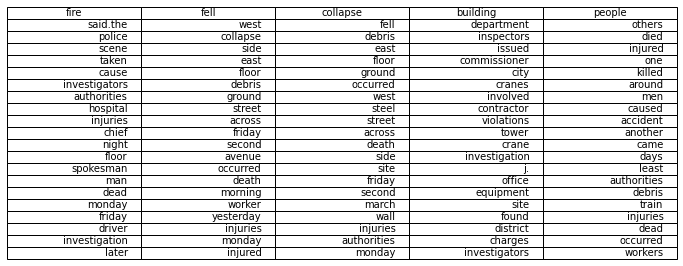

In [898]:
from matplotlib.backends.backend_pdf import PdfPages
fig, ax = plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText = df_keyword.values, colLabels = df_keyword.columns, loc = 'center')
pp = PdfPages("simlist.pdf")
pp.savefig(fig,bbox_inches = 'tight')

In [899]:
df_keyword

,fire,fell,collapse,building,people
0,said.the,west,fell,department,others
1,police,collapse,debris,inspectors,died
2,scene,side,east,issued,injured
3,taken,east,floor,commissioner,one
4,cause,floor,ground,city,killed
5,investigators,debris,occurred,cranes,around
6,authorities,ground,west,involved,men
7,hospital,street,steel,contractor,caused
8,injuries,across,street,violations,accident
9,chief,friday,across,tower,another


In [702]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from umap import UMAP

In [703]:
from umap import UMAP
reducer = UMAP(n_neighbors =5, min_dist =0.1, n_components = 2, verbose = True)

In [704]:
len(token_sentence)

861

In [762]:
X = model[model.wv.vocab]

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [763]:
#list of word
X_l = list(model.wv.vocab)
print(len(X_l))
#print(X_l)

285


In [764]:
X.shape

(285, 400)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=5, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Thu Apr  9 13:27:07 2020 Finding Nearest Neighbors
Thu Apr  9 13:27:07 2020 Finished Nearest Neighbor Search
Thu Apr  9 13:27:07 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Apr  9 13

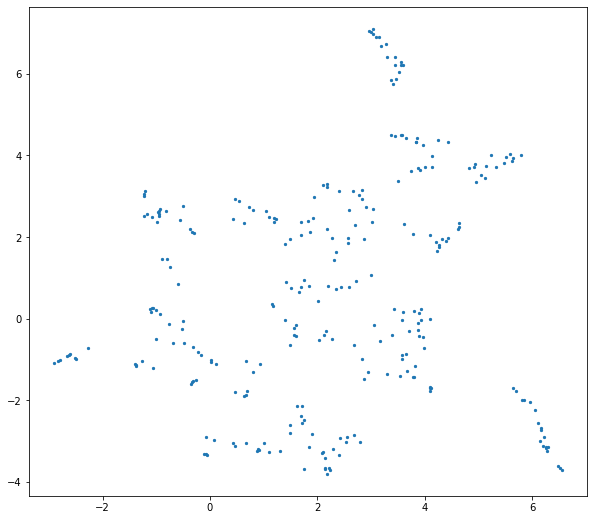

In [765]:
cluster_embedding = reducer.fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:,0], cluster_embedding[:,1],s=5,cmap='tab10')

In [766]:
df = pd.DataFrame(cluster_embedding)

In [767]:
#coordinate of words

df

,0,1
0,-0.807685,1.462215
1,4.197803,1.868301
2,2.138629,-3.408409
3,1.486671,-2.618109
4,2.795085,-3.027621
...,...,...
280,-2.277071,-0.721042
281,-2.621548,-0.886539
282,1.106151,2.491671
283,-2.652903,-0.914760


Text(0.5, 1.0, 'Word Embdding results with UMAP')

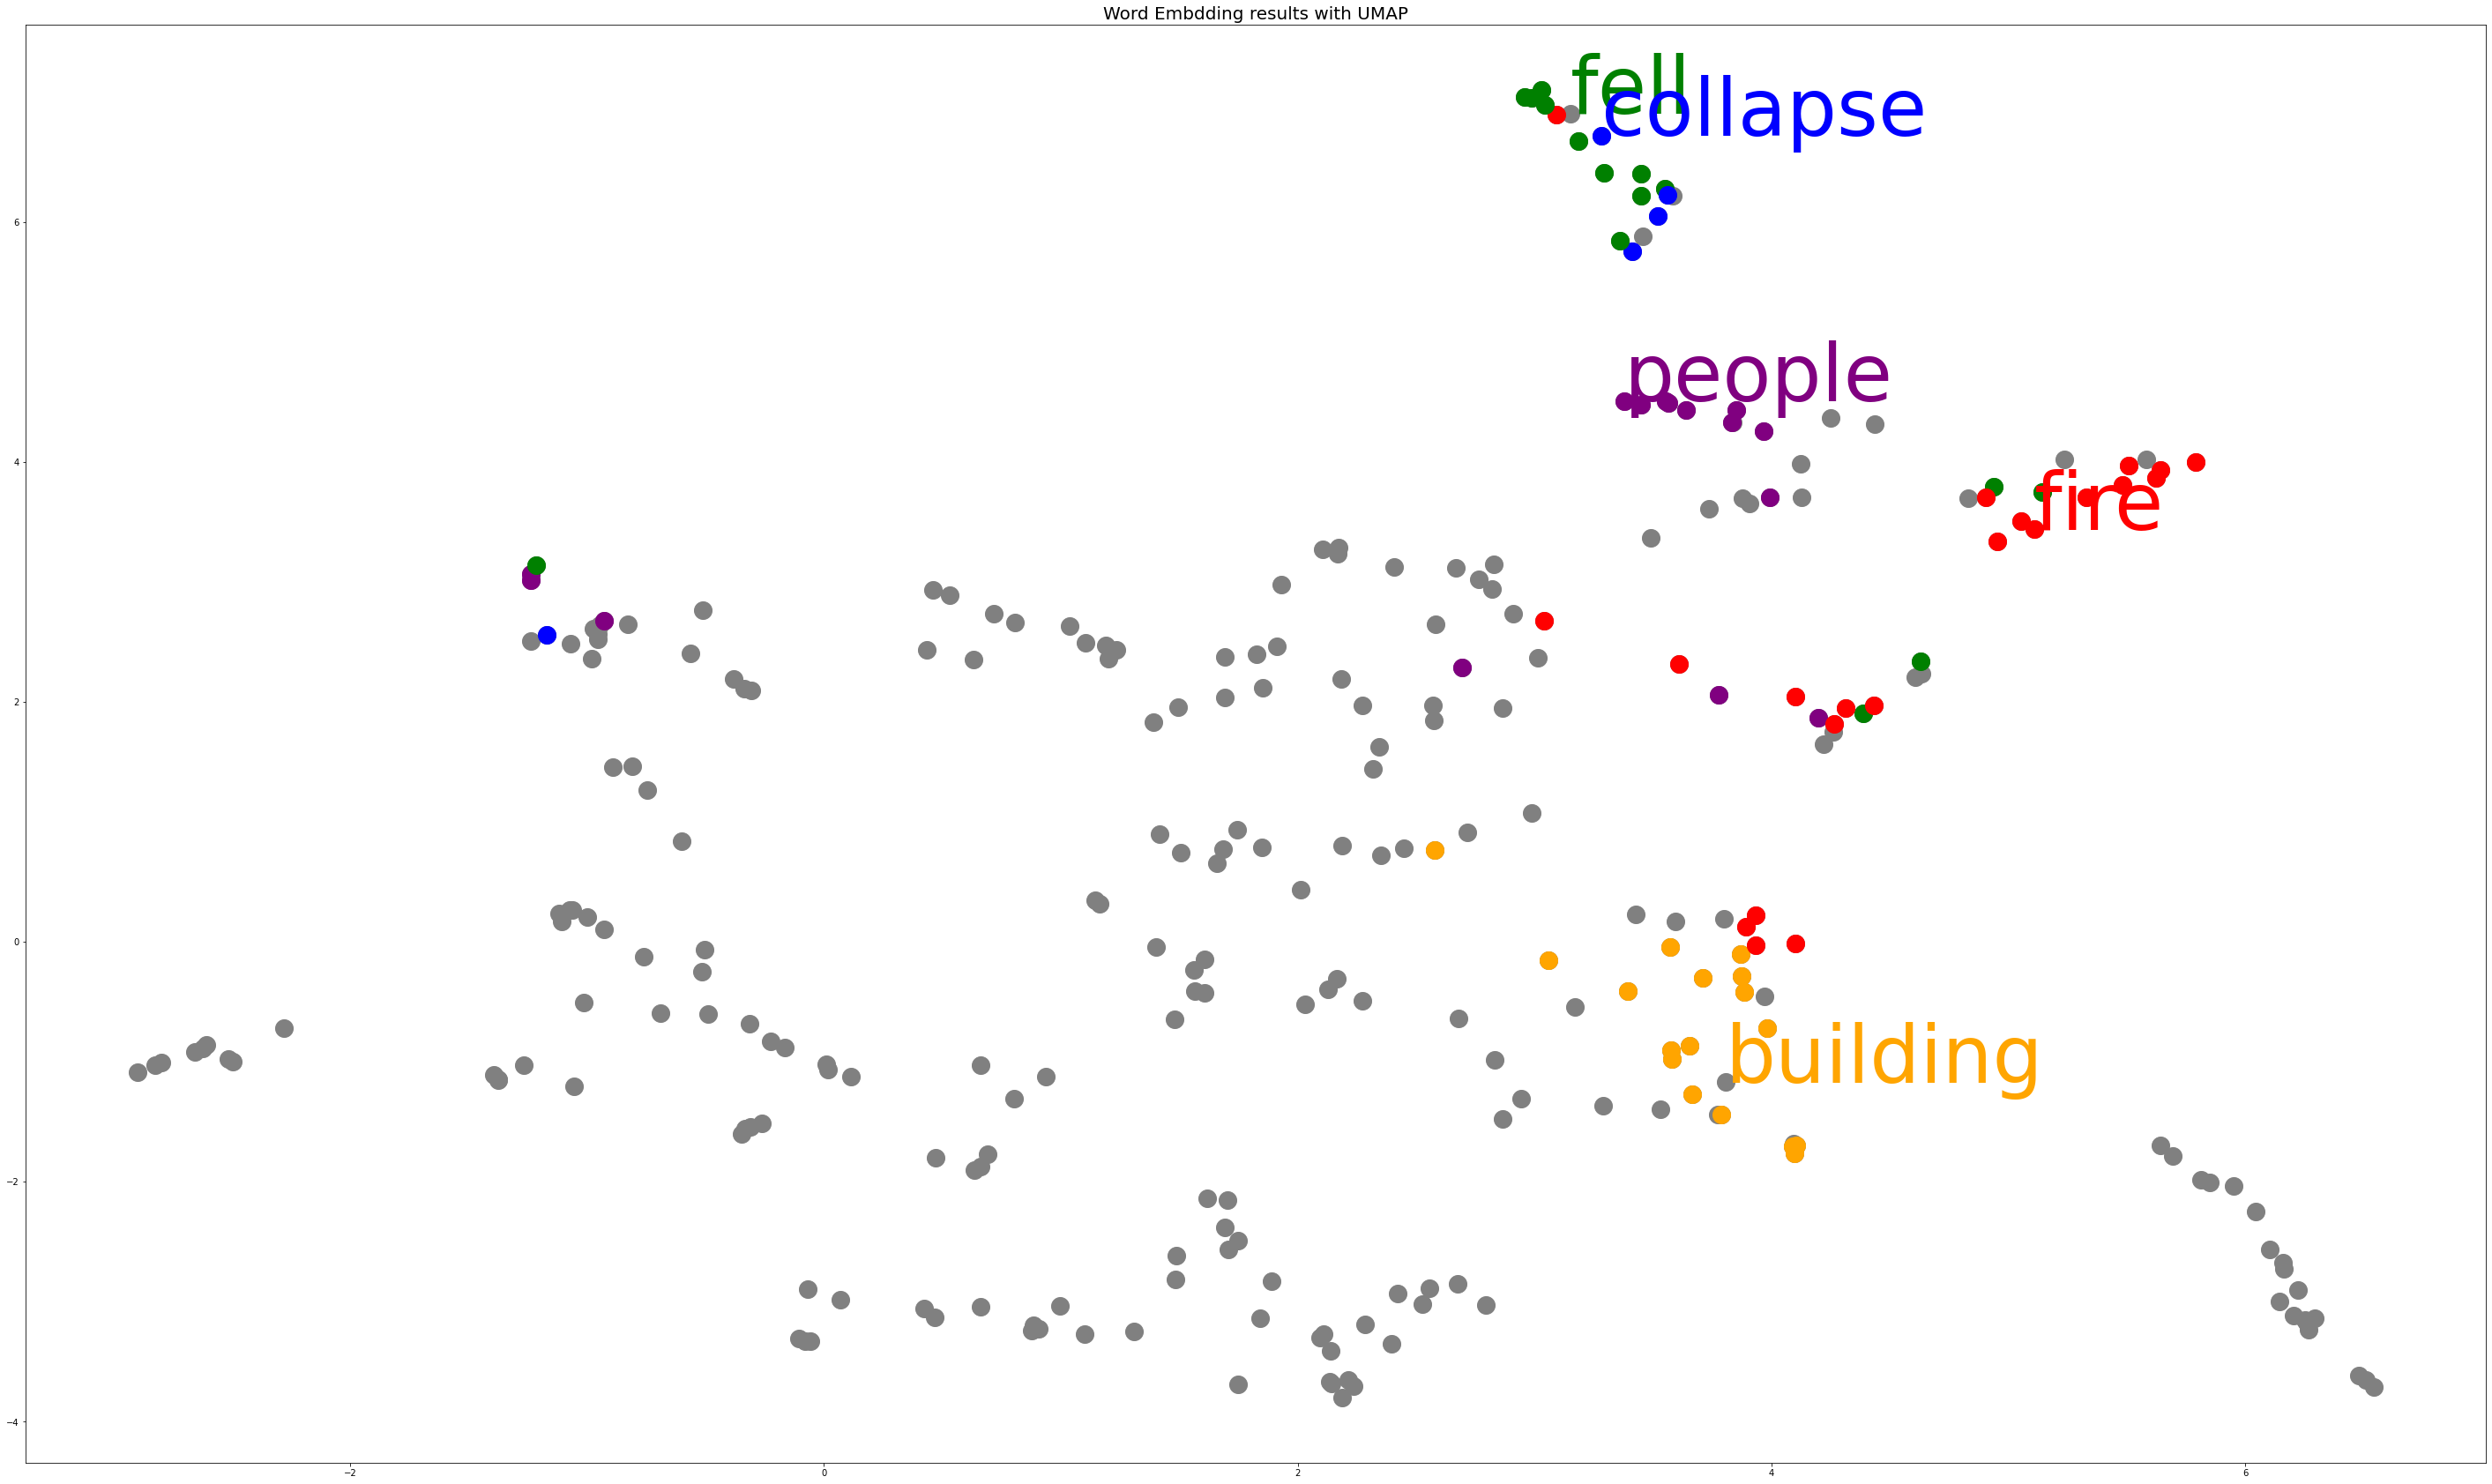

In [1209]:
fig = plt.figure()
fig.set_size_inches(50,30)
ax = fig.add_subplot(1,1,1)

#colors = [0,0,0,1,0,1]

ax.scatter(df[0],df[1], s =400, c = 'grey')

for i, txt in enumerate(X_l):
    
    if txt == 'fire' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color = 'red', fontsize=90)
        ax.scatter(df.loc[i][0],df.loc[i][1], s =400, color = "red")
    elif txt in sim_fire_word :
        #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='red', fontsize=8)
        ax.scatter(df.loc[i][0],df.loc[i][1], s =400, color = "red")

    elif txt =='collapse' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color = 'blue', fontsize=90)
        ax.scatter(df.loc[i][0],df.loc[i][1], s =400, color = "blue")
        
    elif txt =='fell' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]),color='green', fontsize=90)
        
    elif txt in sim_fall_word :
        #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='green', fontsize=8)  
        ax.scatter(df.loc[i][0],df.loc[i][1], s =400, color = "green")
    

        
    elif txt in sim_collapse_word :
        #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='blue', fontsize=8)
        ax.scatter(df.loc[i][0],df.loc[i][1], s =400, color = "blue")
    
    elif txt =='building' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='orange', fontsize=90)
        
    elif txt in sim_building_word :
        #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='orange', fontsize=8)
        ax.scatter(df.loc[i][0],df.loc[i][1], s =400, color = "orange")
      
    
    elif txt =='people' :
        ax.annotate(txt, (df.loc[i][0],df.loc[i][1]),color = 'purple', fontsize=90)
        ax.scatter(df.loc[i][0],df.loc[i][1], s =400, color = "purple")
    elif txt in sim_people_word :
        #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='purple', fontsize=8)
        ax.scatter(df.loc[i][0],df.loc[i][1], s =400, color = "purple")
    #else :
        #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), fontsize=8)
plt.title ("Word Embdding results with UMAP", fontsize = 20)
#plt.savefig('fire_word2vec_0521_best_fell.pdf')

In [1267]:
def sizecons(size) :    
    fig = plt.figure()
    fig.set_size_inches(50,30)
    ax = fig.add_subplot(1,1,1)

#colors = [0,0,0,1,0,1]

    ax.scatter(df[0],df[1], s =size, c = 'grey', edgecolor = 'black')

    for i, txt in enumerate(X_l):
    
        if txt == 'fire' :
            #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color = 'red', fontsize=90)
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "red", edgecolor = 'black')
        elif txt in sim_fire_word :
        #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='red', fontsize=8)
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "red", edgecolor = 'black')

        elif txt =='collapse' :
            #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color = 'blue', fontsize=90)
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "blue", edgecolor = 'black')
        
        elif txt =='fell' :
            #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]),color='green', fontsize=90)
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "green", edgecolor = 'black')
        
        elif txt in sim_fall_word :
            #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='green', fontsize=8)  
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "green", edgecolor = 'black')
    

        
        elif txt in sim_collapse_word :
        #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='blue', fontsize=8)
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "blue", edgecolor = 'black')
    
        elif txt =='building' :
            #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='orange', fontsize=90)
             ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "orange", edgecolor = 'black')
        elif txt in sim_building_word :
        #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='orange', fontsize=8)
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "orange", edgecolor = 'black')
      
    
        elif txt =='people' :
            #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]),color = 'purple', fontsize=90)
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "purple", edgecolor = 'black')
        elif txt in sim_people_word :
        #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='purple', fontsize=8)
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "purple", edgecolor = 'black')
    #else :
        #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), fontsize=8)
    #plt.title ("Word Embdding results with UMAP", fontsize = 20)
    fig.tight_layout()
    plt.savefig('Figure/word2vec/word2vec_all.pdf')

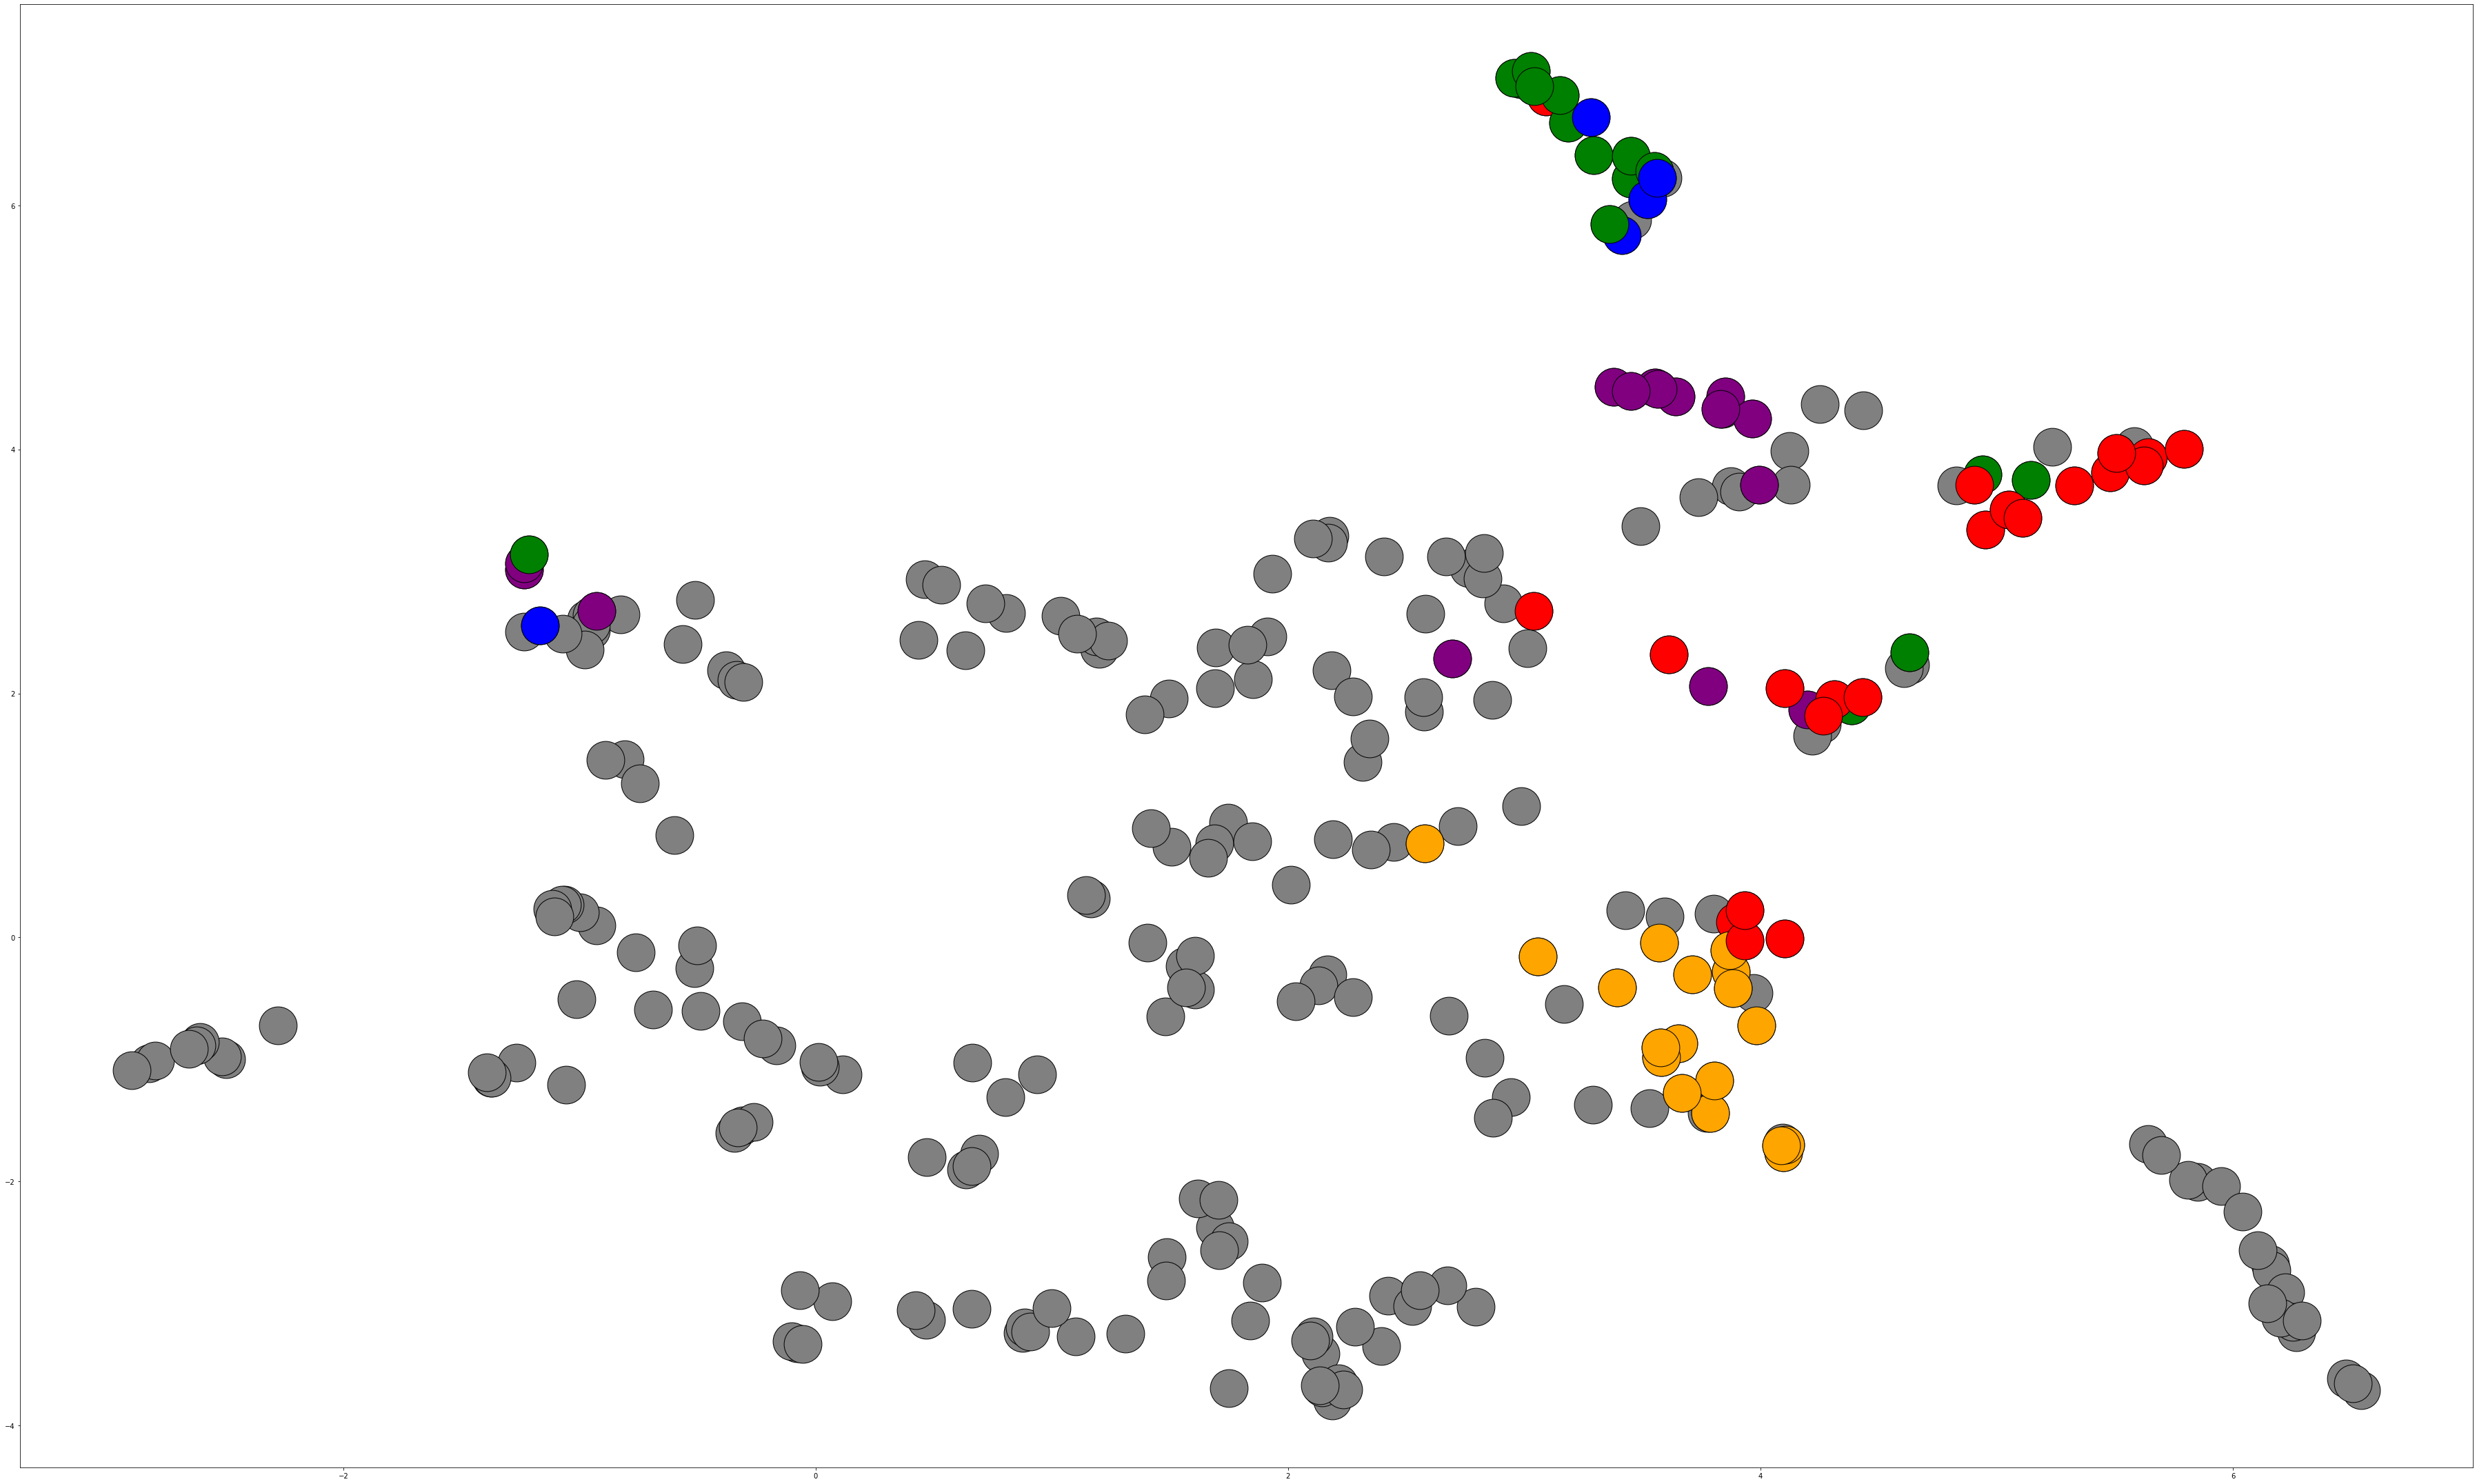

In [1268]:
sizecons(3000)

In [1369]:
def sizecons(size) :    
    fig = plt.figure()
    fig.set_size_inches(50,30)
    ax = fig.add_subplot(1,1,1)

#colors = [0,0,0,1,0,1]

    ax.scatter(df[0],df[1], s =size, c = 'grey', edgecolor = 'black')

    for i, txt in enumerate(X_l):
    
        if txt == 'fire' :
            #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color = 'red', fontsize=30, textcoords = 'offset points')
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "red", edgecolor = 'black')
        elif txt in sim_fire_word :
            if txt != "said.the" :    
                #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='black', fontsize=17, textcoords = 'offset points')
            
                ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "red", edgecolor = 'black')
        elif txt =='collapse' :
            ax.annotate('collapsed', (df.loc[i][0],df.loc[i][1]), color = 'blue', fontsize=30, textcoords = "offset points")
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "blue", edgecolor = 'black')
        
        elif txt in sim_collapse_word :
            #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='black', fontsize=17, textcoords = "offset points")
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "blue", edgecolor = 'black')            

            
        elif txt =='fell' :
            #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]),color='green', fontsize=30, textcoords = "offset points")
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "green", edgecolor = 'black')
        
        elif txt in sim_fall_word :
            #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='black', fontsize=17, textcoords= "offset points")  
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "green", edgecolor = 'black')    
            

        
        elif txt =='building' :
            #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='orange', fontsize=30,textcoords= "offset points")
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "orange", edgecolor = 'black')
        elif txt in sim_building_word :
            #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='black', fontsize=17, textcoords= "offset points")
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "orange", edgecolor = 'black')
      
    
        elif txt =='people' :
            #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]),color = 'purple', fontsize=30, textcoords= "offset points", rotation =45)
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "purple", edgecolor = 'black')
        elif txt in sim_people_word :
            ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), color ='black', fontsize=17, textcoords= "offset points")
            ax.scatter(df.loc[i][0],df.loc[i][1], s =size, color = "purple", edgecolor = 'black')
    #else :
        #ax.annotate(txt, (df.loc[i][0],df.loc[i][1]), fontsize=8)
    #plt.title ("Word Embdding results with UMAP", fontsize = 20)
    fig.tight_layout()
    #plt.savefig('Figure/word2vec/word2vec_subgraph_people.pdf')
    
    
    

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


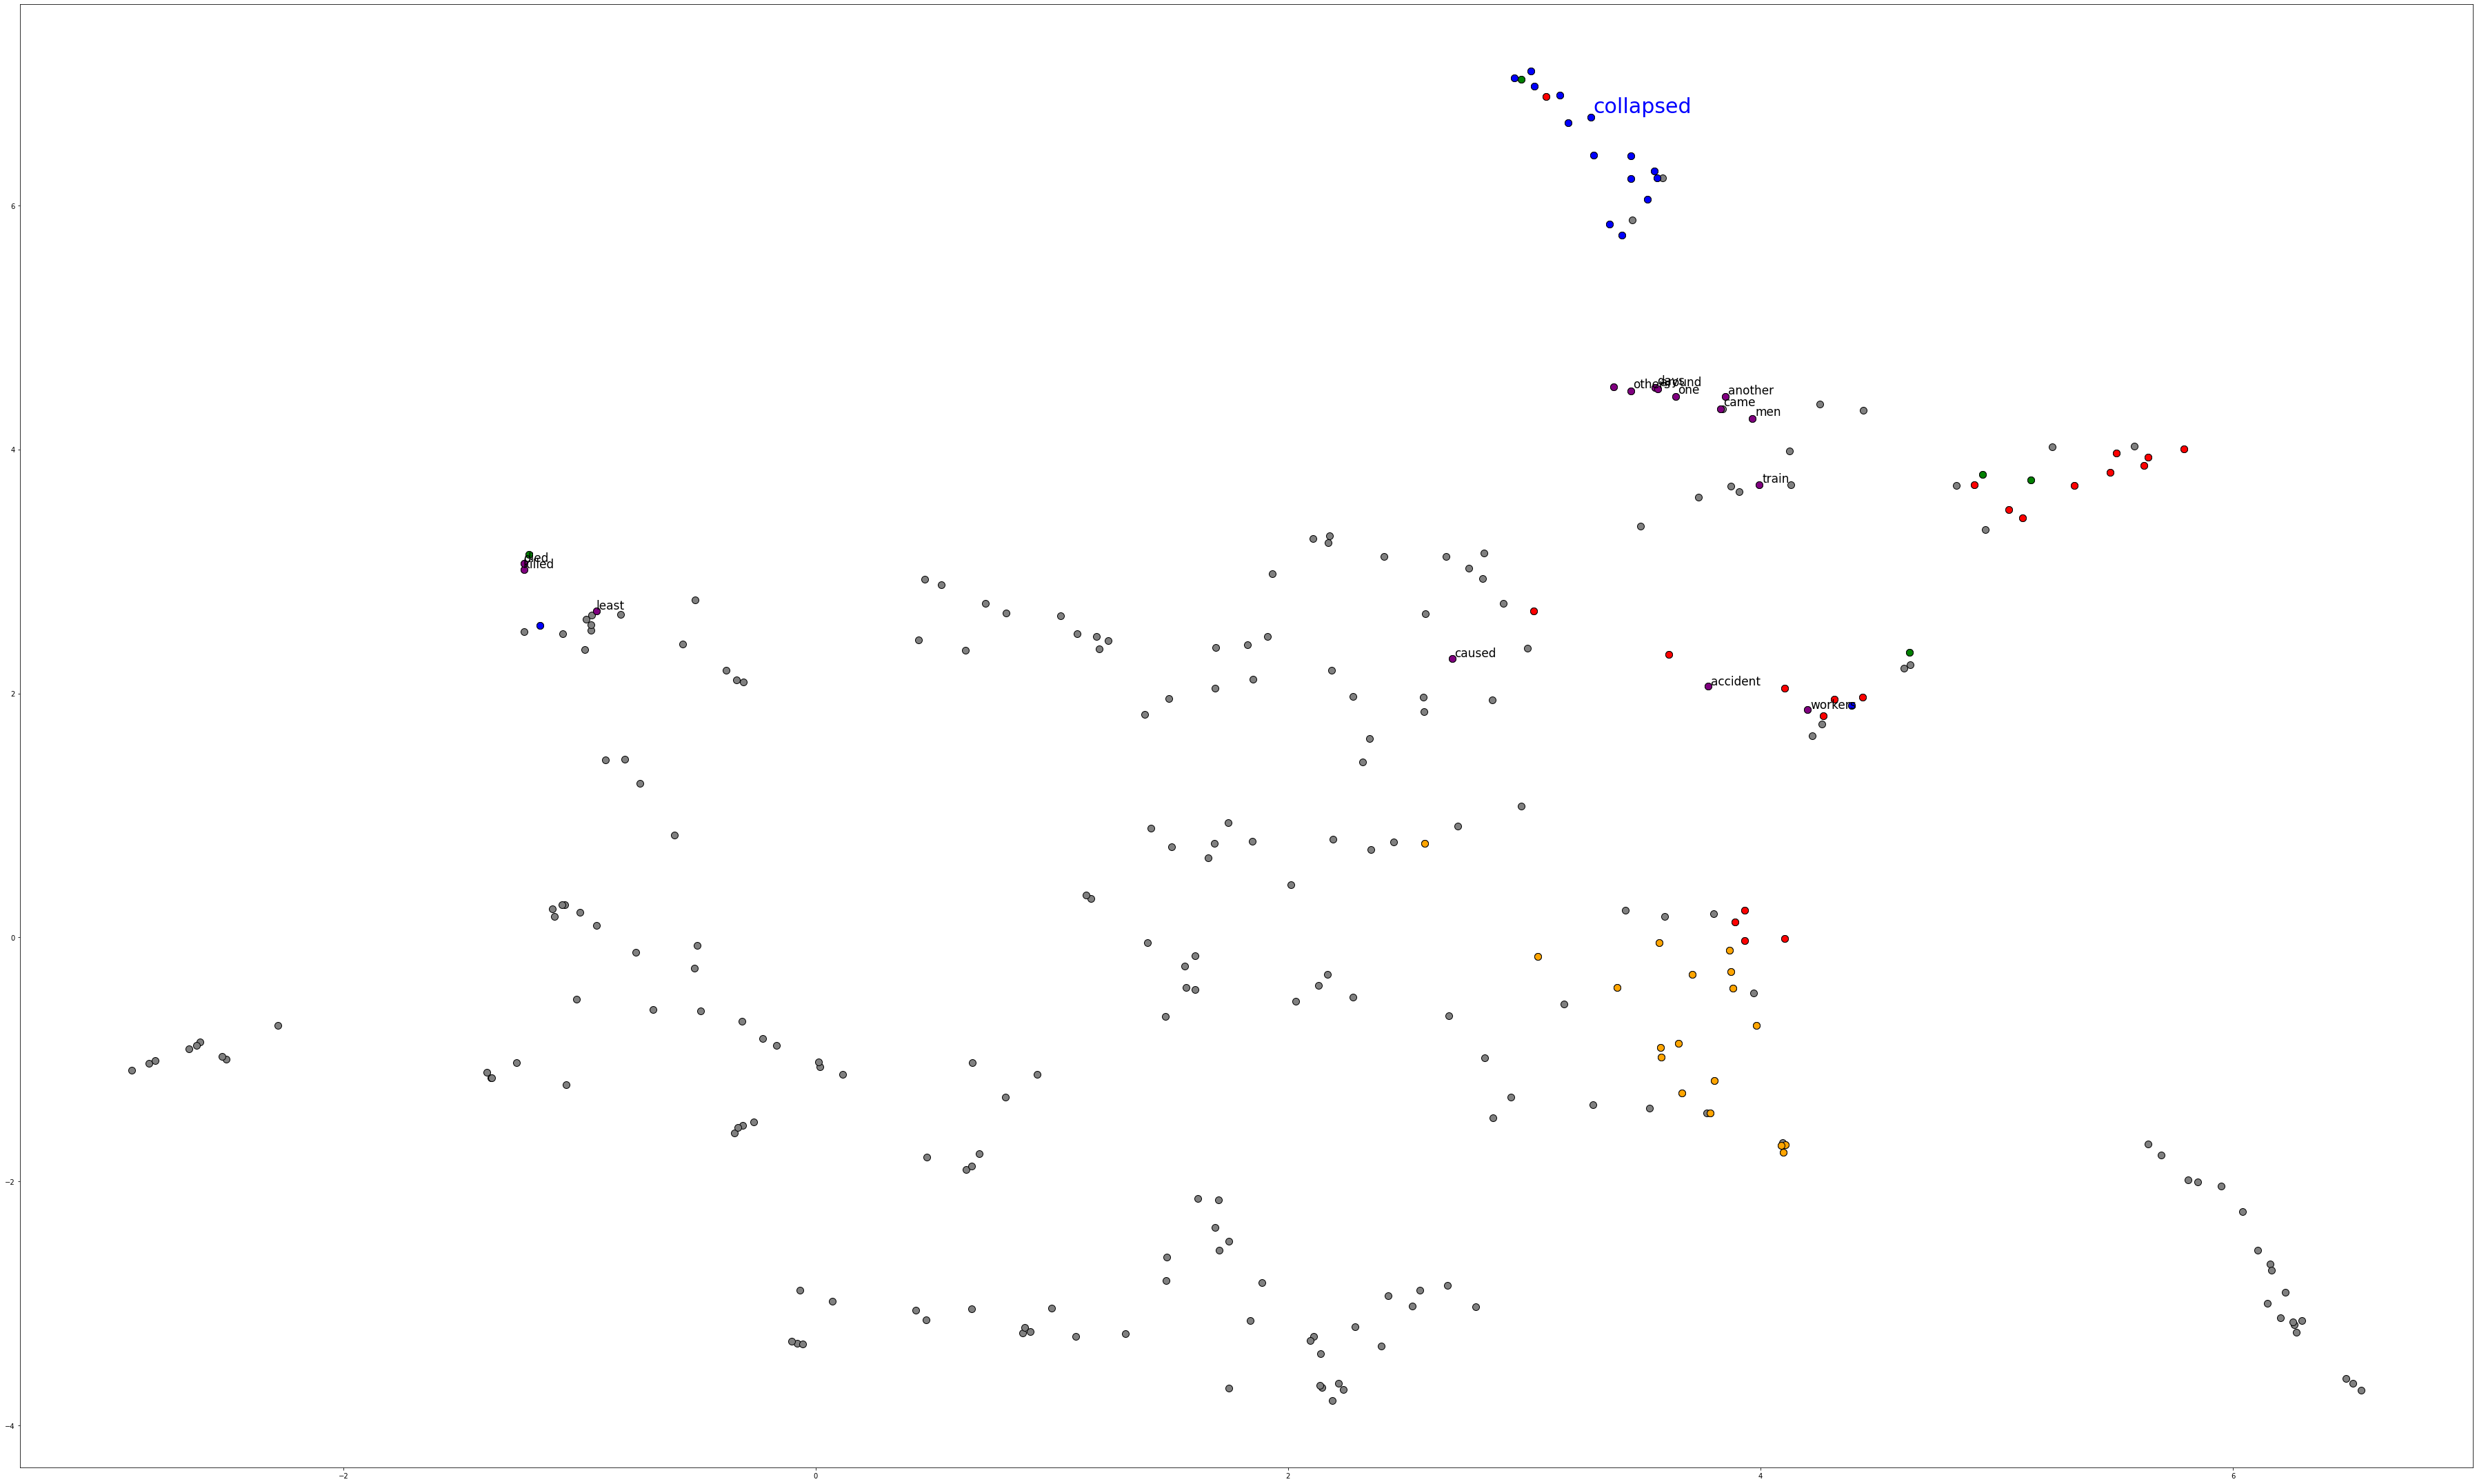

In [1371]:
sizecons(100)